# Stochastic Kinematically Informed Earthquake Sequences (SKIES)
1. Calculate kinematically informed random epicenter
     $$P(c(t)) = \frac{1}{1+e^{-c(t)}} + \mathrm{history}$$
     where $c(t)$ is the coupling rate at time ($t$).  This is an instantaneous formulation.  We could also do this with a more history dependent formulation.  This could include dropping probabilities after an event ruptures a triangular element much like a "state" effect.  This could sort of halo certain regions
2. Calculate random magnitude from Gutenberg-Richter distribution with a minimum magnitude based on minimum triangle area 
3. Calculate approximate rupture area, $a$ with empirical scaling law (Allen and Hayes, 2017)
4. Find subset of $n$ triangles with areas $a_n$ that sum to $a$ some factor
5. Calculate eigenfunctions for these triangles
6. Generate random Gaussian slip pattern from randomly weighted eigenvectors
7. Sigmoid scaling of slip with distance from the hypocenter so that it tapers to zero at rupture edge
8. Rescale random Gaussian slip pattern to get the magnitude correct

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import datetime
import json
import meshio
import os
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import matplotlib
import cm_xml_to_matplotlib as make_cmap

# import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Constants and parameters
N_GRID_X = 500
N_GRID_Y = 500
MAKE_EIGENVECTOR_EXAMPLE_PLOT = False
N_CONTOUR_LEVELS = 10
AREA_SCALING = 1.25 # Increases rupture area to partially compensate for sigmoid filtering
RADIUS_EARTH = 6371e3 # (m)
KM2_TO_M2 = 1e6 # kilometers squared to meters squared
KM2M = 1.0e3
DYNECM_TO_NM = 1e-7 # dynes centimeters to Newton meters
SHEAR_MODULUS = 3e10 # Shear modulus (Pa)

cmap = make_cmap.make_cmap("w_ymiddle1.xml")

In [4]:
def get_mesh_edge_elements(meshes):
    # Find indices of elements lining top, bottom, and sides of each mesh

    get_ordered_edge_nodes(meshes)

    for i in range(len(meshes)):
        coords = meshes[i].meshio_object.points
        vertices = meshes[i].verts

        # Arrays of all element side node pairs
        side_1 = np.sort(np.vstack((vertices[:, 0], vertices[:, 1])).T, 1)
        side_2 = np.sort(np.vstack((vertices[:, 1], vertices[:, 2])).T, 1)
        side_3 = np.sort(np.vstack((vertices[:, 2], vertices[:, 0])).T, 1)

        # Sort edge node array
        sorted_edge_nodes = np.sort(meshes[i].ordered_edge_nodes, 1)

        # Indices of element sides that are in edge node array
        side_1_in_edge, side_1_in_edge_idx = ismember(sorted_edge_nodes, side_1, "rows")
        side_2_in_edge, side_2_in_edge_idx = ismember(sorted_edge_nodes, side_2, "rows")
        side_3_in_edge, side_3_in_edge_idx = ismember(sorted_edge_nodes, side_3, "rows")

        # Depths of nodes
        side_1_depths = np.abs(
            coords[
                np.column_stack(
                    (side_1[side_1_in_edge_idx, :], vertices[side_1_in_edge_idx, 2])
                ),
                2,
            ]
        )
        side_2_depths = np.abs(
            coords[
                np.column_stack(
                    (side_2[side_2_in_edge_idx, :], vertices[side_2_in_edge_idx, 0])
                ),
                2,
            ]
        )
        side_3_depths = np.abs(
            coords[
                np.column_stack(
                    (side_3[side_3_in_edge_idx, :], vertices[side_3_in_edge_idx, 1])
                ),
                2,
            ]
        )
        # Top elements are those where the depth difference between the non-edge node
        # and the mean of the edge nodes is greater than the depth difference between
        # the edge nodes themselves
        top1 = (side_1_depths[:, 2] - np.mean(side_1_depths[:, 0:2], 1)) > (
            np.abs(side_1_depths[:, 0] - side_1_depths[:, 1])
        )
        top2 = (side_2_depths[:, 2] - np.mean(side_2_depths[:, 0:2], 1)) > (
            np.abs(side_2_depths[:, 0] - side_2_depths[:, 1])
        )
        top3 = (side_3_depths[:, 2] - np.mean(side_3_depths[:, 0:2], 1)) > (
            np.abs(side_3_depths[:, 0] - side_3_depths[:, 1])
        )
        tops = np.full(len(vertices), False, dtype=bool)
        tops[side_1_in_edge_idx[top1]] = True
        tops[side_2_in_edge_idx[top2]] = True
        tops[side_3_in_edge_idx[top3]] = True
        meshes[i].top_elements = tops

        # Bottom elements are those where the depth difference between the non-edge node
        # and the mean of the edge nodes is more negative than the depth difference between
        # the edge nodes themselves
        bot1 = side_1_depths[:, 2] - np.mean(side_1_depths[:, 0:2], 1) < -np.abs(
            side_1_depths[:, 0] - side_1_depths[:, 1]
        )
        bot2 = side_2_depths[:, 2] - np.mean(side_2_depths[:, 0:2], 1) < -np.abs(
            side_2_depths[:, 0] - side_2_depths[:, 1]
        )
        bot3 = side_3_depths[:, 2] - np.mean(side_3_depths[:, 0:2], 1) < -np.abs(
            side_3_depths[:, 0] - side_3_depths[:, 1]
        )
        bots = np.full(len(vertices), False, dtype=bool)
        bots[side_1_in_edge_idx[bot1]] = True
        bots[side_2_in_edge_idx[bot2]] = True
        bots[side_3_in_edge_idx[bot3]] = True
        meshes[i].bot_elements = bots

        # Side elements are a set difference between all edges and tops, bottoms
        sides = np.full(len(vertices), False, dtype=bool)
        sides[side_1_in_edge_idx] = True
        sides[side_2_in_edge_idx] = True
        sides[side_3_in_edge_idx] = True
        sides[np.where(tops != 0)] = False
        sides[np.where(bots != 0)] = False
        meshes[i].side_elements = sides


def get_ordered_edge_nodes(meshes):
    """Find exterior edges of each mesh and return them in the dictionary
    for each mesh.

    Args:
        meshes (List): list of mesh dictionaries
    """

    for i in range(len(meshes)):
        # Make side arrays containing vertex indices of sides
        vertices = meshes[i].verts
        side_1 = np.sort(np.vstack((vertices[:, 0], vertices[:, 1])).T, 1)
        side_2 = np.sort(np.vstack((vertices[:, 1], vertices[:, 2])).T, 1)
        side_3 = np.sort(np.vstack((vertices[:, 2], vertices[:, 0])).T, 1)
        all_sides = np.vstack((side_1, side_2, side_3))
        unique_sides, sides_count = np.unique(all_sides, return_counts=True, axis=0)
        edge_nodes = unique_sides[np.where(sides_count == 1)]

        meshes[i].ordered_edge_nodes = np.zeros_like(edge_nodes)
        meshes[i].ordered_edge_nodes[0, :] = edge_nodes[0, :]
        last_row = 0
        for j in range(1, len(edge_nodes)):
            idx = np.where(
                (edge_nodes == meshes[i].ordered_edge_nodes[j - 1, 1])
            )  # Edge node indices the same as previous row, second column
            next_idx = np.where(
                idx[0][:] != last_row
            )  # One of those indices is the last row itself. Find the other row index
            next_row = idx[0][next_idx]  # Index of the next ordered row
            next_col = idx[1][next_idx]  # Index of the next ordered column (1 or 2)
            if next_col == 1:
                next_col_ord = [1, 0]  # Flip edge ordering
            else:
                next_col_ord = [0, 1]
            meshes[i].ordered_edge_nodes[j, :] = edge_nodes[next_row, next_col_ord]
            last_row = (
                next_row  # Update last_row so that it's excluded in the next iteration
            )


def inpolygon(xq, yq, xv, yv):
    """From: https://stackoverflow.com/questions/31542843/inpolygon-examples-of-matplotlib-path-path-contains-points-method

    Args:
        xq : x coordinates of points to test
        yq : y coordinates of points to test
        xv : x coordinates of polygon vertices
        yv : y coordinates of polygon vertices

    Returns:
        _type_: Boolean like for in or out of polygon
    """
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def get_synthetic_accumulated_slip(mesh, sources):
    slip_distribution = np.zeros(2 * mesh.n_tde)
    strike_slip_distribution = np.zeros(mesh.n_tde)
    dip_slip_distribution = np.zeros(mesh.n_tde)

    for i in range(sources.lon.size):
        source_to_mesh_centroid_lon = mesh.centroids[:, 0] - sources.lon[i]
        source_to_mesh_centroid_lat = mesh.centroids[:, 1] - sources.lat[i]

        source_to_mesh_centroid_distance = np.sqrt(
            source_to_mesh_centroid_lon**2.0 + source_to_mesh_centroid_lat**2.0
        )

        # Guassian slip pattern
        if sources.slip_type[i] == "strike_slip":
            strike_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )
        elif sources.slip_type[i] == "dip_slip":
            dip_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )

    slip_distribution[0::2] = strike_slip_distribution  # Strike slip only
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    return slip_distribution


def plot_meshes(meshes, fill_value, ax, cmap_string):
    x_coords = meshes[0].meshio_object.points[:, 0]
    y_coords = meshes[0].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[0].verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor="k",
        cmap=cmap_string,
        linewidth=0.1,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    return pc


def moment_magnitude_to_area_allen_and_hayes(moment_magnitude):
    """Calculate emperically estimated slip areas using
    relationships from:

    Allen and Hayes (2017), Alternative Rupture-Scaling
    Relationships for Subduction Interface and Other Offshore
    Environments, Bulletin of the Seismological Society of America,
    Vol. 107, No. 3, pp. 1240–1253, June 2017, doi: 10.1785/0120160255

    All values taken from their table 2

    Note: $S_2$ in the paper's notation is what we use for rupture_area

    Args:
        moment_magnitude: Array of moment magnitudes

    Returns:
        area: rupture area in meters squared
    """
    hinge_moment_magnitude = 8.63
    if moment_magnitude <= hinge_moment_magnitude:
        a = -5.62
        b = 1.22
    elif moment_magnitude > hinge_moment_magnitude:
        a = 2.23
        b = 0.31
    area = KM2_TO_M2 * 10 ** (a + b * moment_magnitude)
    return area


def get_gutenberg_richter_magnitudes(n_earthquakes, b_value, minimum_magnitude):
    rng = np.random.RandomState()
    magnitudes = minimum_magnitude + rng.exponential(
        1.0 / (-b_value / np.log10(np.e)), n_earthquakes
    )
    return magnitudes


def normalized_sigmoid(a, b, x):
    """
    Returns array of a horizontal mirrored normalized sigmoid function
    output between 0 and 1
    Function parameters a = center; b = width
    https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python
    """
    s = 1 / (1 + np.exp(b * (x - a)))
    return 1 * (s - np.min(s)) / (np.max(s) - np.min(s))  # normalize function to 0-1


# Visualize eigenvectors
def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


def get_hypocenter_triangle_to_all_triangles_distances(meshes, event):
    # Find distance between current index mesh triangle all others
    x_centroid = (
        meshes[0].x_centroid[event.hypocenter_triangle_index] - meshes[0].x_centroid
    )
    y_centroid = (
        meshes[0].y_centroid[event.hypocenter_triangle_index] - meshes[0].y_centroid
    )
    z_centroid = (
        meshes[0].z_centroid[event.hypocenter_triangle_index] - meshes[0].z_centroid
    )

    all_triangle_cartesian_centroid_coordinates = np.vstack(
        (x_centroid, y_centroid, z_centroid)
    ).T

    hypocenter_triangle_cartesian_centroid_coordinates = np.array(
        [
            x_centroid[event.hypocenter_triangle_index],
            y_centroid[event.hypocenter_triangle_index],
            z_centroid[event.hypocenter_triangle_index],
        ]
    ).T

    hypocenter_triangle_to_all_triangles_distances = scipy.spatial.distance.cdist(
        hypocenter_triangle_cartesian_centroid_coordinates,
        all_triangle_cartesian_centroid_coordinates,
        "euclidean",
    )

    hypocenter_triangle_to_all_triangles_distances = np.squeeze(
        hypocenter_triangle_to_all_triangles_distances
    )

    return hypocenter_triangle_to_all_triangles_distances


def event_generate_slip(event, eigenvalues, eigenvectors):
    event.slip = np.zeros(event.triangle_index.size)
    weights = np.random.randn(eigenvalues.size)
    for k in range(1, weights.size):
        event.slip += weights[k] * np.sqrt(eigenvalues[k]) * eigenvectors[:, k]
    event.slip = np.exp(event.slip)

    # Apply taper to slip.  This is ad hoc and may need revision
    distances = event.hypocenter_triangle_to_all_triangles_distances[
        event.triangle_index
    ]
    taper_transition = 1.5 * np.mean(distances)
    taper_width = 10 / taper_transition  # m

    slip_taper = normalized_sigmoid(taper_transition, taper_width, distances)
    event.slip = event.slip * slip_taper

    # After taper is applied rescale slip magnitudes to get the correct moment
    event.pre_scaled_moment = SHEAR_MODULUS * np.sum(
        event.slip * meshes[0].areas[event.triangle_index]
    )
    event.slip_scaling_factor = event.moment / event.pre_scaled_moment
    event.slip = event.slip * event.slip_scaling_factor

    event.slip_all_elements = np.zeros(meshes[0].n_tde)
    event.slip_all_elements[event.triangle_index] = event.slip

    return event


def plot_initial_data(meshes, initial_slip_deficit):
    # Plot all mesh data and initial slip deficit condition
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 4, 1)
    pc = plot_meshes(meshes, np.zeros(meshes[0].areas.size), plt.gca(), "Blues")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"{meshes[0].n_tde} triangles")

    plt.subplot(1, 4, 2)
    pc = plot_meshes(meshes, meshes[0].areas / 1e6, plt.gca(), "plasma")
    plt.colorbar(pc, label="triangle areas (km^2)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"{np.sum(meshes[0].areas) / KM2_TO_M2:0.2f} (km^2)")

    plt.subplot(1, 4, 3)
    pc = plot_meshes(meshes, initial_slip_deficit, plt.gca(), "inferno_r")
    plt.colorbar(pc, label="initial slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"{np.max(initial_slip_deficit):0.2f} (m)")


def plot_event(event, meshes, pre_event_slip_deficit, probability, post_event_slip_deficit, t):
    # Plot distances from current event hypocenter triangle
    plt.figure(figsize=(20, 3))

    # Plot pre-earthquake slip deficit
    plt.subplot(1, 6, 1)
    pc = plot_meshes(meshes, pre_event_slip_deficit, plt.gca(), "magma_r")
    plt.colorbar(pc, label="initial slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"pre-earthquake slip deficit")

    # Plot current probability
    plt.subplot(1, 6, 2)
    pc = plot_meshes(meshes, probability, plt.gca(), "viridis_r")
    plt.colorbar(pc, label="initial slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"probability")

    plt.subplot(1, 6, 3)
    pc = plot_meshes(
        meshes,
        event.hypocenter_triangle_to_all_triangles_distances / 1e3,
        plt.gca(),
        "Reds",
    )
    plt.colorbar(pc, label="distance to hypocenter triangle")
    plt.plot(
        meshes[0].centroids[event.hypocenter_triangle_index, 0],
        meshes[0].centroids[event.hypocenter_triangle_index, 1],
        "*k",
        markersize=15,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"index = {event.hypocenter_triangle_index[0]}")

    # Plot triangles involved in current event
    plt.subplot(1, 6, 4)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value[event.triangle_index] = 1
    pc = plot_meshes(meshes, fill_value, plt.gca(), "Blues")
    plt.colorbar(pc, label="event triangles")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"{event.actual_area / KM2_TO_M2:0.2f} (km)")

    # Plot slip distribution
    plt.subplot(1, 6, 5)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value[event.triangle_index] = event.slip
    x_coords = meshes[0].meshio_object.points[:, 0]
    y_coords = meshes[0].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[0].verts)
    ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor=None,
        cmap="gnuplot2_r",
        linewidth=0,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.colorbar(pc, label="slip (m)")
    plt.title(f"M_W = {event.moment_magnitude[0]:0.3}")

    plt.subplot(1, 6, 6)
    pc = plot_meshes(meshes, post_event_slip_deficit, plt.gca(), "magma_r")
    plt.colorbar(pc, label="slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"post-earthquake slip deficit")

    plt.suptitle(f"{t=}")
    plt.show()

def area_to_moment_magnitude_allen_and_hayes(area):
    """Calculate emperically estimated slip areas using
    relationships from:

    Allen and Hayes (2017), Alternative Rupture-Scaling
    Relationships for Subduction Interface and Other Offshore
    Environments, Bulletin of the Seismological Society of America,
    Vol. 107, No. 3, pp. 1240–1253, June 2017, doi: 10.1785/0120160255

    All values taken from their table 2

    Note: $S_2$ in the paper's notation is what we use for rupture_area

    Args:
        moment_magnitude: Array of moment magnitudes

    Returns:
        area: rupture area in meters squared
    """
    hinge_area = 80714792455.11925 # (m)
    if area <= hinge_area:
        a = -5.62
        b = 1.22
    elif area > hinge_area:
        a = 2.23
        b = 0.31
    moment_magnitude = (np.log10(area / KM2_TO_M2) - a) / b
    return moment_magnitude

In [5]:
def create_event(meshes, probability):
    # Dictionary for storing `event` information for a single earthquake
    event = addict.Dict()

    # Select random event magnitude from GR distribution
    n_earthquakes = 1
    b_value = -1.0
    minimum_magnitude = 8.0
    event.moment_magnitude = get_gutenberg_richter_magnitudes(
        n_earthquakes, b_value, minimum_magnitude
    )

    event.moment = 10 ** (1.5 * (event.moment_magnitude + 10.7) - 7.0)
    event.target_area = AREA_SCALING * moment_magnitude_to_area_allen_and_hayes(
        event.moment_magnitude
    )
    event.total_mesh_area = np.sum(meshes[0].areas)

    # Select random triangle, should be based on coupling or slip deficit rate/history
    triangle_probabilities = probability
    event.hypocenter_triangle_index = np.random.choice(
        meshes[0].n_tde, 1, p=triangle_probabilities
    )

    # Calculate distance from hypocenter triangle toto all other triangles
    event.hypocenter_triangle_to_all_triangles_distances = (
        get_hypocenter_triangle_to_all_triangles_distances(meshes, event)
    )

    # Find the triangles close to the hypocenter that accumulate enough area to be a
    # part of the event rupture
    sorted_distance_index = np.argsort(
        event.hypocenter_triangle_to_all_triangles_distances
    )
    cumulative_area = np.cumsum(meshes[0].areas[sorted_distance_index])
    event.triangle_index = sorted_distance_index[
        np.where(cumulative_area < event.target_area)[0]
    ]
    event.actual_area = np.sum(meshes[0].areas[event.triangle_index])
    event.mean_slip = event.moment / (SHEAR_MODULUS * event.actual_area)

    # Calculate eigenvalues and eigenvectors for the current event area
    # Were not storing these in event because that would start to consume a
    # lot of RAM as we build histories of multiple events
    event.n_eigenvalues = event.triangle_index.size
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        event.n_eigenvalues,
        (meshes[0].x_centroid[event.hypocenter_triangle_index] - meshes[0].x_centroid)[
            event.triangle_index
        ],
        (meshes[0].y_centroid[event.hypocenter_triangle_index] - meshes[0].y_centroid)[
            event.triangle_index
        ],
        (meshes[0].z_centroid[event.hypocenter_triangle_index] - meshes[0].z_centroid)[
            event.triangle_index
        ],
    )

    # Generate random slip distribution for current rupture patch
    event = event_generate_slip(event, eigenvalues, eigenvectors)
    return event


def get_probability(slip_deficit, t):
    # Map slip defict to earthquake probability
    slip_deficit[slip_deficit < 0.0] = 0.0
    probability = 1 - normalized_sigmoid(1e-5, 1e-1, slip_deficit)
    probability = probability - np.min(probability)
    probability = probability / np.max(probability)
    probability = probability / np.sum(probability)
    return probability


def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z


def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r


def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon


In [6]:
# def create_output_folder(command):
#     # Check to see if "runs" folder exists and if not create it
#     if not os.path.exists(command.base_runs_folder):
#         os.mkdir(command.base_runs_folder)

#     # Make output folder for current run
#     os.mkdir(command.output_path)


def create_output_folder(base_runs_folder, output_path):
    # Check to see if "runs" folder exists and if not create it
    if not os.path.exists(base_runs_folder):
        os.mkdir(base_runs_folder)

    # Make output folder for current run
    os.mkdir(output_path)



def get_mesh_perimeter(meshes):
    for i in range(len(meshes)):
        x_coords = meshes[i].meshio_object.points[:, 0]
        y_coords = meshes[i].meshio_object.points[:, 1]
        meshes[i].x_perimeter = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
        meshes[i].y_perimeter = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
        meshes[i].x_perimeter = np.append(
            meshes[i].x_perimeter, x_coords[meshes[i].ordered_edge_nodes[0, 0]]
        )
        meshes[i].y_perimeter = np.append(
            meshes[i].y_perimeter, y_coords[meshes[i].ordered_edge_nodes[0, 0]]
        )


def triangle_normal(triangles):
    # The cross product of two sides is a normal vector
    # https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
    return np.cross(
        triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0], axis=1
    )


def triangle_area(triangles):
    # The norm of the cross product of two sides is twice the area
    # https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
    return np.linalg.norm(triangle_normal(triangles), axis=1) / 2.0


# Read mesh data - List of dictionaries version
def read_meshes(mesh_parameters_file_name):
    meshes = []
    if mesh_parameters_file_name != "":
        with open(mesh_parameters_file_name) as f:
            mesh_param = json.load(f)
            print(f"Read: {mesh_parameters_file_name}")

        if len(mesh_param) > 0:
            for i in range(len(mesh_param)):
                meshes.append(addict.Dict())
                meshes[i].meshio_object = meshio.read(mesh_param[i]["mesh_filename"])
                meshes[i].file_name = mesh_param[i]["mesh_filename"]
                meshes[i].verts = meshes[i].meshio_object.get_cells_type("triangle")

                # Expand mesh coordinates
                meshes[i].lon1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 0]
                meshes[i].lon2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 0]
                meshes[i].lon3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 0]
                meshes[i].lat1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 1]
                meshes[i].lat2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 1]
                meshes[i].lat3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 1]
                meshes[i].dep1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 2]
                meshes[i].dep2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 2]
                meshes[i].dep3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 2]
                meshes[i].centroids = np.mean(
                    meshes[i].meshio_object.points[meshes[i].verts, :], axis=1
                )
                # Cartesian coordinates in meters
                meshes[i].x1, meshes[i].y1, meshes[i].z1 = sph2cart(
                    meshes[i].lon1,
                    meshes[i].lat1,
                    RADIUS_EARTH + KM2M * meshes[i].dep1,
                )
                meshes[i].x2, meshes[i].y2, meshes[i].z2 = sph2cart(
                    meshes[i].lon2,
                    meshes[i].lat2,
                    RADIUS_EARTH + KM2M * meshes[i].dep2,
                )
                meshes[i].x3, meshes[i].y3, meshes[i].z3 = sph2cart(
                    meshes[i].lon3,
                    meshes[i].lat3,
                    RADIUS_EARTH + KM2M * meshes[i].dep3,
                )

                # Cartesian triangle centroids
                meshes[i].x_centroid = (meshes[i].x1 + meshes[i].x2 + meshes[i].x3) / 3.0
                meshes[i].y_centroid = (meshes[i].y1 + meshes[i].y2 + meshes[i].y3) / 3.0
                meshes[i].z_centroid = (meshes[i].z1 + meshes[i].z2 + meshes[i].z3) / 3.0

                # Cross products for orientations
                tri_leg1 = np.transpose(
                    [
                        np.deg2rad(meshes[i].lon2 - meshes[i].lon1),
                        np.deg2rad(meshes[i].lat2 - meshes[i].lat1),
                        (1 + KM2M * meshes[i].dep2 / RADIUS_EARTH)
                        - (1 + KM2M * meshes[i].dep1 / RADIUS_EARTH),
                    ]
                )
                tri_leg2 = np.transpose(
                    [
                        np.deg2rad(meshes[i].lon3 - meshes[i].lon1),
                        np.deg2rad(meshes[i].lat3 - meshes[i].lat1),
                        (1 + KM2M * meshes[i].dep3 / RADIUS_EARTH)
                        - (1 + KM2M * meshes[i].dep1 / RADIUS_EARTH),
                    ]
                )

                def cross2(a: np.ndarray, b: np.ndarray) -> np.ndarray:
                    """This exists only because of a Pylance reporting complication
                    associated with a numpy stub bug for np.cross:
                    https://github.com/microsoft/pylance-release/issues/3277#issuecomment-1237782014
                    
                    This function simply exists to eliminate the cosmetics of a 
                    incorrect "code unreachable".

                    If numpy fixes this bug we can go back to the sensible:
                    meshes[i].nv = np.cross(tri_leg1, tri_leg2)
                    """
                    return np.cross(a, b)
                meshes[i].nv = cross2(tri_leg1, tri_leg2)
                
                azimuth, elevation, r = cart2sph(
                    meshes[i].nv[:, 0], meshes[i].nv[:, 1], meshes[i].nv[:, 2]
                )
                meshes[i].strike = wrap2360(-np.rad2deg(azimuth))
                meshes[i].dip = 90 - np.rad2deg(elevation)
                meshes[i].dip_flag = meshes[i].dip != 90
                meshes[i].smoothing_weight = mesh_param[i]["smoothing_weight"]
                meshes[i].top_slip_rate_constraint = mesh_param[i][
                    "top_slip_rate_constraint"
                ]
                meshes[i].bot_slip_rate_constraint = mesh_param[i][
                    "bot_slip_rate_constraint"
                ]
                meshes[i].side_slip_rate_constraint = mesh_param[i][
                    "side_slip_rate_constraint"
                ]
                meshes[i].n_tde = meshes[i].lon1.size

                # Calcuate areas of each triangle in mesh
                triangle_vertex_array = np.zeros((meshes[i].n_tde, 3, 3))
                triangle_vertex_array[:, 0, 0] = meshes[i].x1
                triangle_vertex_array[:, 1, 0] = meshes[i].x2
                triangle_vertex_array[:, 2, 0] = meshes[i].x3
                triangle_vertex_array[:, 0, 1] = meshes[i].y1
                triangle_vertex_array[:, 1, 1] = meshes[i].y2
                triangle_vertex_array[:, 2, 1] = meshes[i].y3
                triangle_vertex_array[:, 0, 2] = meshes[i].z1
                triangle_vertex_array[:, 1, 2] = meshes[i].z2
                triangle_vertex_array[:, 2, 2] = meshes[i].z3
                meshes[i].areas = triangle_area(triangle_vertex_array)
                get_mesh_edge_elements(meshes)
                print(f"Read: {mesh_param[i]['mesh_filename']}")
            get_mesh_perimeter(meshes)
    return meshes

In [7]:
# COMMAND_FILE_NAME = "../data/command/western_north_america_command_dense.json"
# COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"

# command = celeri.get_command(COMMAND_FILE_NAME)
# celeri.create_output_folder(command)
# logger = celeri.get_logger(command)
# segment, block, meshes, station, mogi, sar = celeri.read_data(command)

run_name = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
base_runs_folder = "../runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
meshes = read_meshes(mesh_parameters_file_name)


Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: ../data/mesh/cascadia.msh


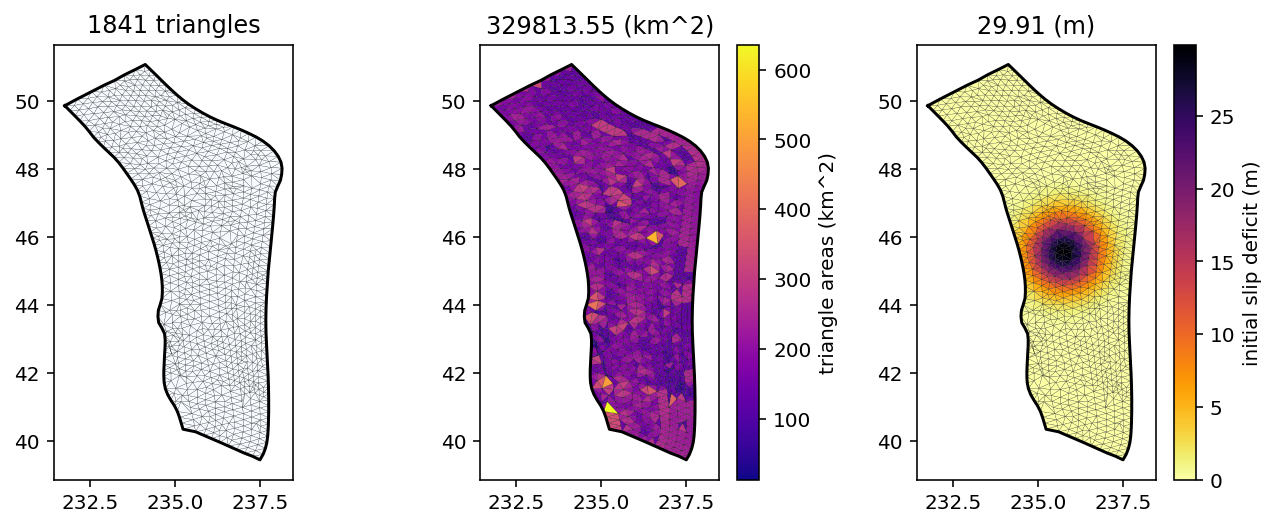

In [8]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([30.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]
slip_deficit = np.copy(initial_dip_slip_deficit)
plot_initial_data(meshes, initial_dip_slip_deficit)


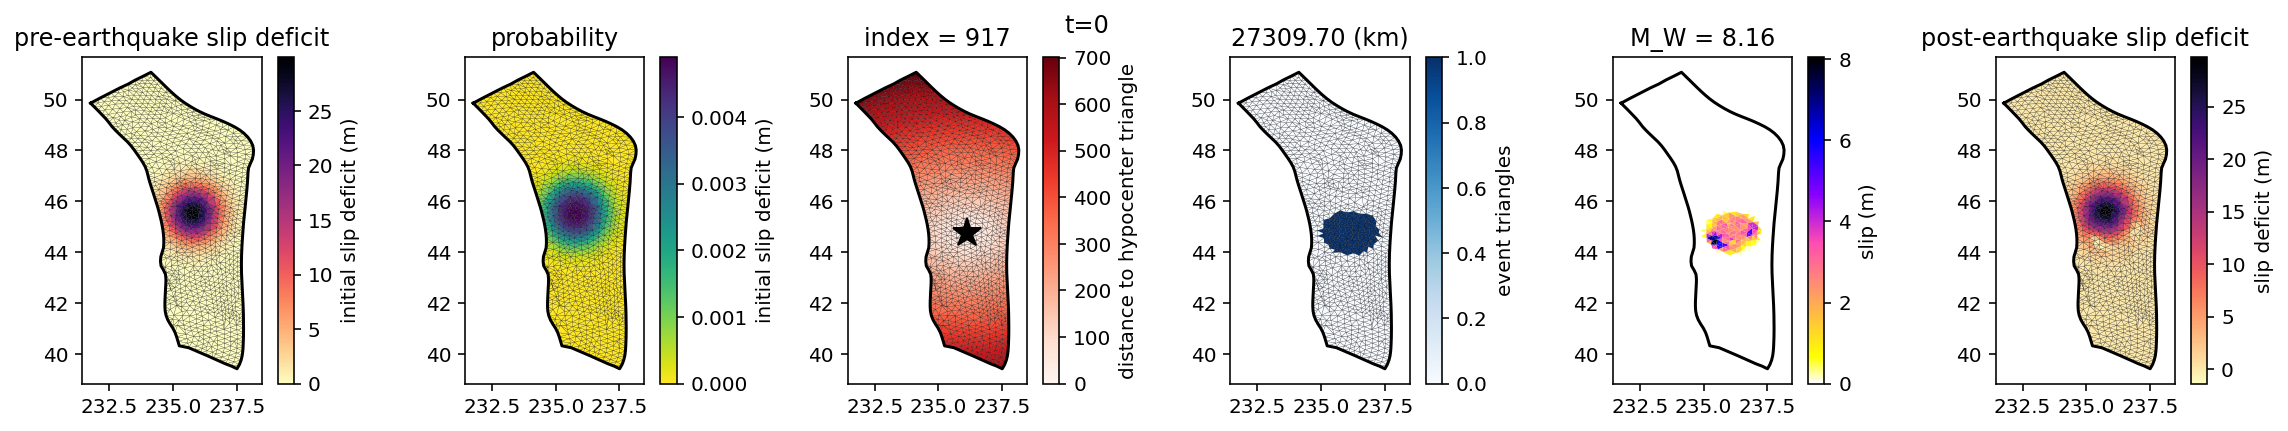

Event data:
Hypocenter longitude = 236.1356 (deg)
Hypocenter latitude = 44.7723 (deg)
Hypocenter depth = -28.1339 (km)
Hypocenter triangle index = 917
Mean slip = 2.40 (m)
Minimum slip = 0.00 (m)
Maximum slip = 8.05 (m)
Moment magnitude = 8.164401445879557
Moment = 1.98e+21 (N m)
Number of eigenvalues = 148
Rupture area = 27309.70 (km^2)
Scaling law rupture area = 27382.92 (km^2)


In [9]:
t = 0
probability = get_probability(initial_dip_slip_deficit, t)
pre_event_slip_deficit = initial_dip_slip_deficit
event = create_event(meshes, probability)
post_event_slip_deficit = slip_deficit - event.slip_all_elements
plot_event(event, meshes, pre_event_slip_deficit, probability, post_event_slip_deficit, t)

print("Event data:")
print(f"Hypocenter longitude = {meshes[0].centroids[event.hypocenter_triangle_index, 0][0]:0.4f} (deg)")
print(f"Hypocenter latitude = {meshes[0].centroids[event.hypocenter_triangle_index, 1][0]:0.4f} (deg)")
print(f"Hypocenter depth = {meshes[0].centroids[event.hypocenter_triangle_index, 2][0]:0.4f} (km)")
print(f"Hypocenter triangle index = {event.hypocenter_triangle_index[0]}")
print(f"Mean slip = {np.mean(event.slip):0.2f} (m)")
print(f"Minimum slip = {np.min(event.slip):0.2f} (m)")
print(f"Maximum slip = {np.max(event.slip):0.2f} (m)")
print(f"Moment magnitude = {event.moment_magnitude[0]}")
print(f"Moment = {event.moment[0]:0.3} (N m)")
print(f"Number of eigenvalues = {event.n_eigenvalues}")
print(f"Rupture area = {event.actual_area / 1e6:0.2f} (km^2)")
print(f"Scaling law rupture area = {event.target_area[0] / 1e6:0.2f} (km^2)")


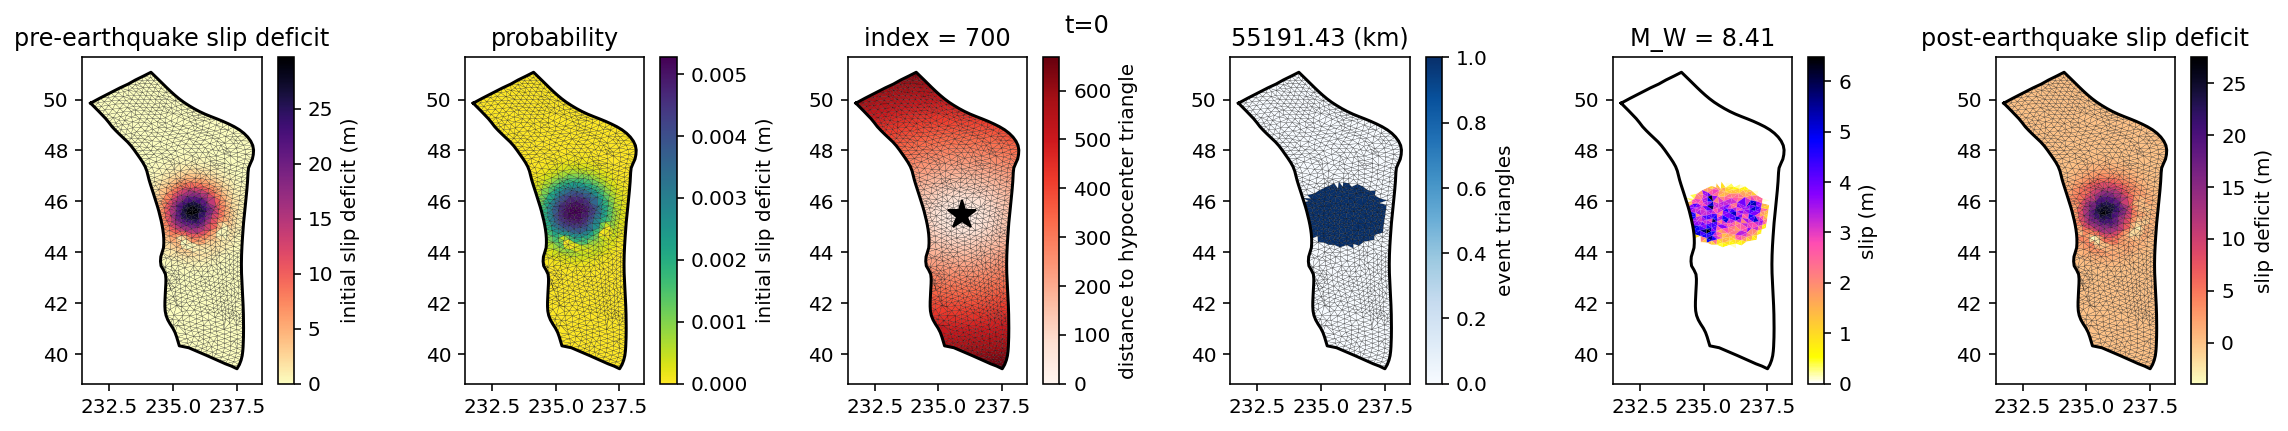

Event data:
Hypocenter longitude = 235.9142 (deg)
Hypocenter latitude = 45.4523 (deg)
Hypocenter depth = -23.2679 (km)
Hypocenter triangle index = 700
Mean slip = 2.82 (m)
Minimum slip = 0.00 (m)
Maximum slip = 6.47 (m)
Moment magnitude = 8.41485486053205
Moment = 4.7e+21 (N m)
Number of eigenvalues = 309
Rupture area = 55191.43 (km^2)
Scaling law rupture area = 55339.21 (km^2)


In [10]:
pre_event_slip_deficit = post_event_slip_deficit
probability = get_probability(pre_event_slip_deficit, t)
event = create_event(meshes, probability)
post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements
plot_event(event, meshes, pre_event_slip_deficit, probability, post_event_slip_deficit, t)

print("Event data:")
print(f"Hypocenter longitude = {meshes[0].centroids[event.hypocenter_triangle_index, 0][0]:0.4f} (deg)")
print(f"Hypocenter latitude = {meshes[0].centroids[event.hypocenter_triangle_index, 1][0]:0.4f} (deg)")
print(f"Hypocenter depth = {meshes[0].centroids[event.hypocenter_triangle_index, 2][0]:0.4f} (km)")
print(f"Hypocenter triangle index = {event.hypocenter_triangle_index[0]}")
print(f"Mean slip = {np.mean(event.slip):0.2f} (m)")
print(f"Minimum slip = {np.min(event.slip):0.2f} (m)")
print(f"Maximum slip = {np.max(event.slip):0.2f} (m)")
print(f"Moment magnitude = {event.moment_magnitude[0]}")
print(f"Moment = {event.moment[0]:0.3} (N m)")
print(f"Number of eigenvalues = {event.n_eigenvalues}")
print(f"Rupture area = {event.actual_area / 1e6:0.2f} (km^2)")
print(f"Scaling law rupture area = {event.target_area[0] / 1e6:0.2f} (km^2)")

In [11]:
# TODO: Remove dependence on celeri?  Extract mesh read in function? Just read a mesh_parameters.json file?
# TODO: Case for when area is a single triangle or less
# TODO: Set minimum earthquake size based on smallest mesh element
# TODO: Set max event size
# TODO: Name for slip deficit at each time step
# TODO: Track slip in time
# TODO: Write up eigenvalue shape idea
# TODO: Move text reporting to function
# TODO: Write looping logic


In [12]:
# Potential event magnitude

maximum_event_size = 9.5

minimum_single_triangle_moment_magnitude = area_to_moment_magnitude_allen_and_hayes(
    np.min(meshes[0].areas)
)
print(minimum_single_triangle_moment_magnitude)
maximum_single_triangle_moment_magnitude = area_to_moment_magnitude_allen_and_hayes(
    np.max(meshes[0].areas)
)
print(maximum_single_triangle_moment_magnitude)
maximum_moment_magnitude = area_to_moment_magnitude_allen_and_hayes(
    np.sum(meshes[0].areas)
)
print(maximum_moment_magnitude)


5.5193033376947955
6.904257475775342
10.607317703352278
